In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.cluster.hierarchy import linkage, fcluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime

In [9]:

# ============================================================================
# 1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH
# ============================================================================

print("\n1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH")
print("-" * 50)

# Wczytanie danych
df = pd.read_csv('video games sales.csv')

print(f"📊 Podstawowe informacje o datasecie:")
print(f"   • Liczba rekordów: {len(df):,}")
print(f"   • Liczba kolumn: {len(df.columns)}")
print(f"   • Rozmiar w pamięci: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n📋 Struktura danych:")
print(df.info())

print(f"\n🎯 Pierwsze 5 rekordów:")
print(df.head())

print(f"\n📈 Podstawowe statystyki opisowe:")
print(df.describe())


1. WCZYTANIE I PODSTAWOWA EKSPLORACJA DANYCH
--------------------------------------------------
📊 Podstawowe informacje o datasecie:
   • Liczba rekordów: 16,598
   • Liczba kolumn: 11
   • Rozmiar w pamięci: 4.74 MB

📋 Struktura danych:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB
None

🎯 Pierwsze 5 rekordów:
  

In [10]:

# ============================================================================
# 2. ANALIZA JAKOŚCI DANYCH
# ============================================================================

print("\n\n2. ANALIZA JAKOŚCI DANYCH")
print("-" * 50)

# Sprawdzenie braków danych
print("🔍 Analiza braków danych:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Kolumna': missing_data.index,
    'Liczba braków': missing_data.values,
    'Procent braków': missing_percent.values
})
print(missing_df.to_string(index=False))

# Sprawdzenie duplikatów
print(f"\n🔄 Analiza duplikatów:")
duplicates = df.duplicated().sum()
print(f"   • Kompletne duplikaty: {duplicates}")

# Duplikaty nazw gier (te same gry na różnych platformach)
# UWAGA: To normalne zjawisko - jedna gra na wielu platformach = osobne wydania
name_duplicates = df.groupby('Name').size()
games_with_multiple_platforms = name_duplicates[name_duplicates > 1]
print(f"   • Gry występujące na wielu platformach: {len(games_with_multiple_platforms)}")
print(f"   • To NORMALNE zjawisko - każda platforma = osobna sprzedaż")
print(f"   • Przykłady gier multi-platform:")

for game_name in games_with_multiple_platforms.head(5).index:
    platforms = df[df['Name'] == game_name][['Platform', 'Year', 'Global_Sales']].values
    total_sales = sum([sales for _, _, sales in platforms])
    print(f"     - {game_name}: {len(platforms)} platform, suma: {total_sales:.2f}M")
    for platform, year, sales in platforms[:3]:  # Pokazuj max 3 platformy
        print(f"       → {platform} ({year}): {sales}M")

# Sprawdzenie zakresów danych
print(f"\n📅 Analiza zakresów danych:")
print(f"   • Lata: {df['Year'].min():.0f} - {df['Year'].max():.0f}")
print(f"   • Sprzedaż globalna: {df['Global_Sales'].min():.2f}M - {df['Global_Sales'].max():.2f}M")

# Sprawdzenie niespójności w sumowaniu sprzedaży
calculated_global = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']
sales_difference = np.abs(calculated_global - df['Global_Sales'])
inconsistent_sales = (sales_difference > 0.01).sum()
print(f"   • Niespójności w sumowaniu sprzedaży: {inconsistent_sales} przypadków")




2. ANALIZA JAKOŚCI DANYCH
--------------------------------------------------
🔍 Analiza braków danych:
     Kolumna  Liczba braków  Procent braków
        Rank              0        0.000000
        Name              0        0.000000
    Platform              0        0.000000
        Year            271        1.632727
       Genre              0        0.000000
   Publisher             58        0.349440
    NA_Sales              0        0.000000
    EU_Sales              0        0.000000
    JP_Sales              0        0.000000
 Other_Sales              0        0.000000
Global_Sales              0        0.000000

🔄 Analiza duplikatów:
   • Kompletne duplikaty: 0
   • Gry występujące na wielu platformach: 2775
   • To NORMALNE zjawisko - każda platforma = osobna sprzedaż
   • Przykłady gier multi-platform:
     - 007: Quantum of Solace: 6 platform, suma: 3.92M
       → X360 (2008.0): 1.49M
       → PS3 (2008.0): 1.16M
       → Wii (2008.0): 0.67M
     - 007: The World is not

In [11]:
# ============================================================================
# 2.5. KRYTYCZNA ANALIZA JAKOŚCI DANYCH W CZASIE - OKREŚLENIE ZAKRESU ANALIZY
# ============================================================================

print("\n\n2.5. KRYTYCZNA ANALIZA JAKOŚCI DANYCH W CZASIE")
print("-" * 60)

print("🔍 Analiza liczby gier wydawanych rok po roku:")
yearly_counts = df.groupby('Year').size().sort_index()

# Sprawdzenie trendu - czy rzeczywiście po 2006 było mniej gier?
print(f"\nLiczba gier według dekad:")
for decade in range(1980, 2020, 10):
    decade_games = yearly_counts[(yearly_counts.index >= decade) & (yearly_counts.index < decade + 10)]
    if len(decade_games) > 0:
        total = decade_games.sum()
        avg_per_year = decade_games.mean()
        print(f"   {decade}s: {total} gier (średnio {avg_per_year:.1f}/rok)")

print(f"\nTop i bottom lata według liczby wydanych gier:")
print("Najlepsze lata:")
for year, count in yearly_counts.nlargest(5).items():
    print(f"   {year}: {count} gier")

print("Najsłabsze lata (po 1990):")
recent_years = yearly_counts[yearly_counts.index > 1990]
for year, count in recent_years.nsmallest(5).items():
    print(f"   {year}: {count} gier")

# Analiza sprzedaży w czasie
print(f"\n📈 Analiza sprzedaży w czasie:")
yearly_sales = df.groupby('Year').agg({
    'Global_Sales': ['sum', 'mean', 'count']
}).round(2)
yearly_sales.columns = ['Total_Sales', 'Avg_Sales', 'Games_Count']

print("Lata z najwyższą całkowitą sprzedażą:")
for year, row in yearly_sales.nlargest(5, 'Total_Sales').iterrows():
    print(f"   {year}: {row['Total_Sales']}M (z {row['Games_Count']} gier)")

# Identyfikacja potencjalnego cut-off point
print(f"\n⚠️  REKOMENDACJA ZAKRESU CZASOWEGO:")
# Szukamy punktu gdzie liczba gier drastycznie spada
recent_years_avg = yearly_counts[yearly_counts.index >= 2010].mean()
good_years_avg = yearly_counts[(yearly_counts.index >= 2000) & (yearly_counts.index <= 2009)].mean()

print(f"   • Średnia gier/rok 2000-2009: {good_years_avg:.1f}")
print(f"   • Średnia gier/rok 2010+: {recent_years_avg:.1f}")
print(f"   • Spadek o: {((good_years_avg - recent_years_avg)/good_years_avg*100):.1f}%")

# Znajdź rok cut-off gdzie jakość danych spada
cutoff_year = 2010  # Wstępnie, można dostosować based on data
quality_years = yearly_counts[yearly_counts.index <= cutoff_year]
print(f"\n🎯 PROPONOWANY ZAKRES ANALIZY: 1980-{cutoff_year}")
print(f"   • Obejmuje {len(quality_years)} lat")
print(f"   • {df[df['Year'] <= cutoff_year].shape[0]} gier ({(df[df['Year'] <= cutoff_year].shape[0]/len(df)*100):.1f}% datasetu)")
print(f"   • Stabilny trend bez artefaktów związanych z niepełnymi danymi")



2.5. KRYTYCZNA ANALIZA JAKOŚCI DANYCH W CZASIE
------------------------------------------------------------
🔍 Analiza liczby gier wydawanych rok po roku:

Liczba gier według dekad:
   1980s: 205 gier (średnio 20.5/rok)
   1990s: 1769 gier (średnio 176.9/rok)
   2000s: 9208 gier (średnio 920.8/rok)
   2010s: 5144 gier (średnio 643.0/rok)

Top i bottom lata według liczby wydanych gier:
Najlepsze lata:
   2009.0: 1431 gier
   2008.0: 1428 gier
   2010.0: 1259 gier
   2007.0: 1202 gier
   2011.0: 1139 gier
Najsłabsze lata (po 1990):
   2020.0: 1 gier
   2017.0: 3 gier
   1991.0: 41 gier
   1992.0: 43 gier
   1993.0: 60 gier

📈 Analiza sprzedaży w czasie:
Lata z najwyższą całkowitą sprzedażą:
   2008.0: 678.9M (z 1428.0 gier)
   2009.0: 667.3M (z 1431.0 gier)
   2007.0: 611.13M (z 1202.0 gier)
   2010.0: 600.45M (z 1259.0 gier)
   2006.0: 521.04M (z 1008.0 gier)

⚠️  REKOMENDACJA ZAKRESU CZASOWEGO:
   • Średnia gier/rok 2000-2009: 920.8
   • Średnia gier/rok 2010+: 571.7
   • Spadek o: 37



3. ANALIZA ROZKŁADÓW I OUTLIERÓW
--------------------------------------------------
🎯 Analiza outlierów - Global_Sales:
   • Q1: 0.06M
   • Q3: 0.47M
   • IQR: 0.41M
   • Granice outlierów: -0.55M - 1.08M
   • Liczba outlierów: 1893 (11.4%)

🏆 Top 5 outlierów (najwyższa sprzedaż):
   1. Wii Sports (Wii, 2006): 82.74M
   2. Super Mario Bros. (NES, 1985): 40.24M
   3. Mario Kart Wii (Wii, 2008): 35.82M
   4. Wii Sports Resort (Wii, 2009): 33.0M
   5. Pokemon Red/Pokemon Blue (GB, 1996): 31.37M

📊 WIZUALIZACJA OUTLIERÓW dla oceny granic:


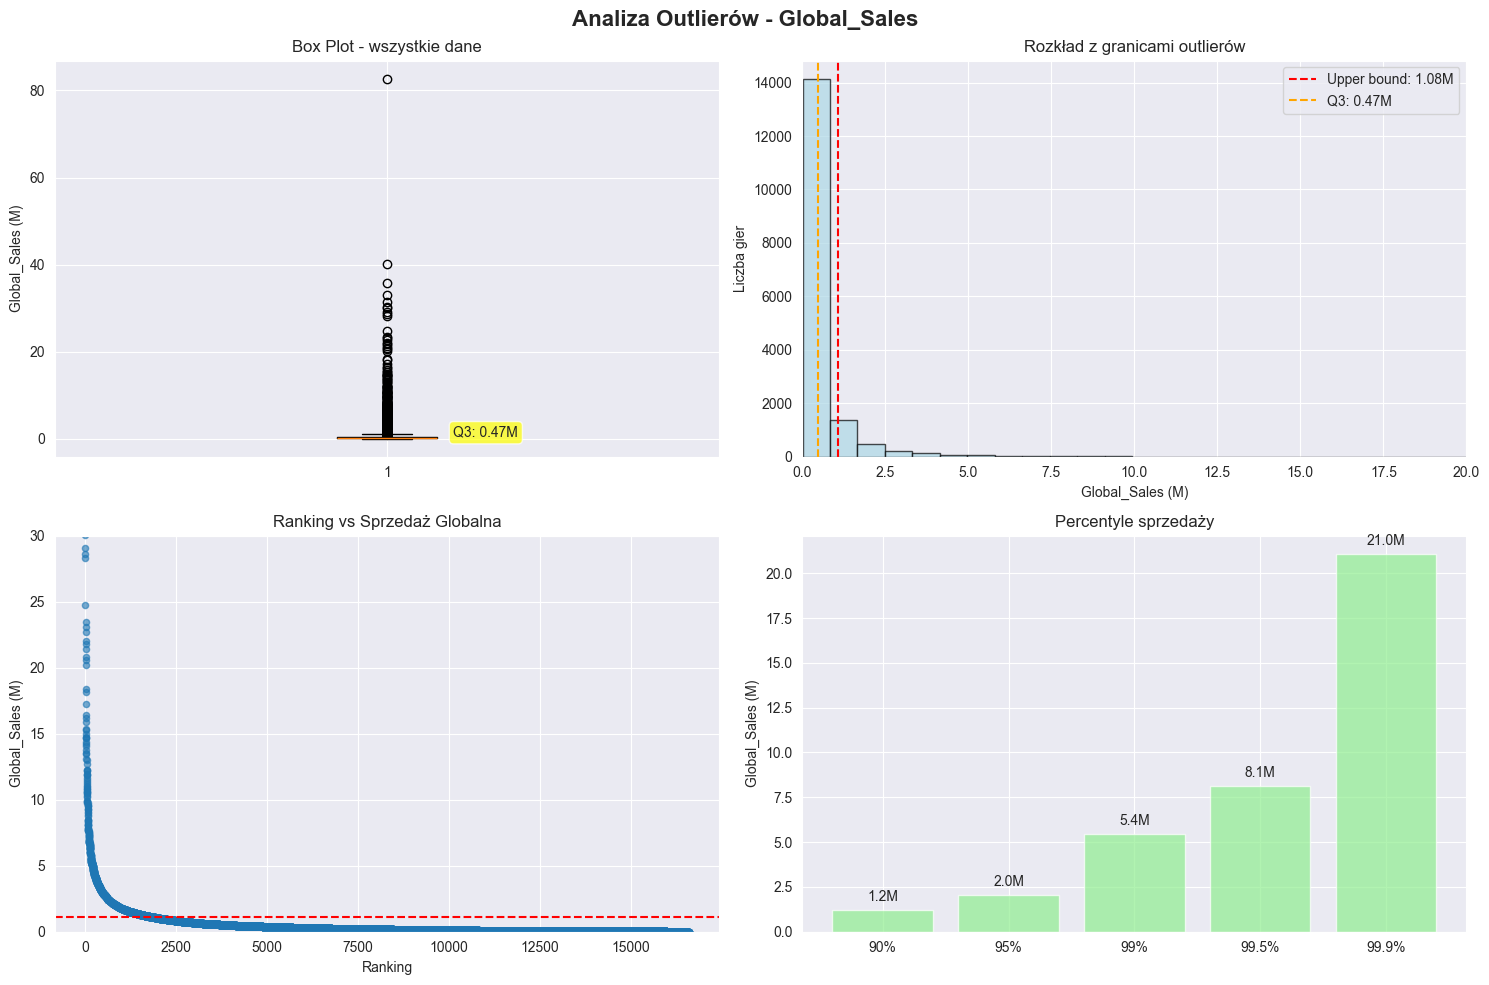


🎯 WNIOSKI dla granic outlierów:
   • Obecna granica (Q3 + 1.5*IQR): 1.08M
   • 95 percentyl: 2.04M
   • 99 percentyl: 5.43M
   • Można rozważyć zmianę granic na 95-99 percentyl zamiast standardowego 1.5*IQR

🌍 Analiza outlierów regionalnych:
   • NA_Sales: 1681 outlierów (10.1%)
   • EU_Sales: 2081 outlierów (12.5%)
   • JP_Sales: 2425 outlierów (14.6%)
   • Other_Sales: 1665 outlierów (10.0%)
   • REKOMENDACJA: Użyj 95 percentyl (2.04M) jako górną granicę outlierów
   • To da bardziej sensowne rezultaty niż sztywne 1.5*IQR

🔧 ALTERNATYWNE GRANICE OUTLIERÓW:
   • Outliers > 95 percentyl (2.04M): 829 gier (5.0%)
   • Outliers > 99 percentyl (5.43M): 166 gier (1.0%)
   • Standard IQR outliers: 1893 gier (11.4%)

💡 ZASTOSOWANIE W ANALIZIE:
   • Analiza główna: wszystkie dane (biznesowa rzeczywistość)
   • Analiza wzorców: bez outlierów > 99 percentyl (statystyczne wzorce)
   • Analiza trendów: data 1980-2010 (jakość danych)


In [12]:

# ============================================================================
# 3. ANALIZA ROZKŁADÓW I OUTLIERÓW
# ============================================================================

print("\n\n3. ANALIZA ROZKŁADÓW I OUTLIERÓW")
print("-" * 50)

# Funkcja do identyfikacji outlierów
def identify_outliers(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    
    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': len(outliers),
        'outliers_percent': (len(outliers) / len(data)) * 100,
        'top_outliers': outliers.nlargest(5, column_name)
    }

# Analiza outlierów dla sprzedaży globalnej
print("🎯 Analiza outlierów - Global_Sales:")
global_outliers = identify_outliers(df, 'Global_Sales')

print(f"   • Q1: {global_outliers['Q1']:.2f}M")
print(f"   • Q3: {global_outliers['Q3']:.2f}M") 
print(f"   • IQR: {global_outliers['IQR']:.2f}M")
print(f"   • Granice outlierów: {global_outliers['lower_bound']:.2f}M - {global_outliers['upper_bound']:.2f}M")
print(f"   • Liczba outlierów: {global_outliers['outliers_count']} ({global_outliers['outliers_percent']:.1f}%)")

print(f"\n🏆 Top 5 outlierów (najwyższa sprzedaż):")
for idx, (_, game) in enumerate(global_outliers['top_outliers'].iterrows(), 1):
    print(f"   {idx}. {game['Name']} ({game['Platform']}, {game['Year']:.0f}): {game['Global_Sales']}M")

# WIZUALIZACJA OUTLIERÓW - jak prosił użytkownik
print(f"\n📊 WIZUALIZACJA OUTLIERÓW dla oceny granic:")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Analiza Outlierów - Global_Sales', fontsize=16, fontweight='bold')

# 1. Box plot z outlierami
axes[0,0].boxplot(df['Global_Sales'], vert=True)
axes[0,0].set_title('Box Plot - wszystkie dane')
axes[0,0].set_ylabel('Global_Sales (M)')
axes[0,0].text(1.1, global_outliers['Q3'], f'Q3: {global_outliers["Q3"]:.2f}M', 
               bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

# 2. Histogram z zaznaczonymi granicami
axes[0,1].hist(df['Global_Sales'], bins=100, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].axvline(global_outliers['upper_bound'], color='red', linestyle='--', 
                  label=f'Upper bound: {global_outliers["upper_bound"]:.2f}M')
axes[0,1].axvline(global_outliers['Q3'], color='orange', linestyle='--',
                  label=f'Q3: {global_outliers["Q3"]:.2f}M')
axes[0,1].set_title('Rozkład z granicami outlierów')
axes[0,1].set_xlabel('Global_Sales (M)')
axes[0,1].set_ylabel('Liczba gier')
axes[0,1].legend()
axes[0,1].set_xlim(0, 20)  # Ograniczenie dla lepszej widoczności

# 3. Scatter plot - ranking vs sprzedaż
axes[1,0].scatter(df['Rank'], df['Global_Sales'], alpha=0.6, s=20)
axes[1,0].axhline(global_outliers['upper_bound'], color='red', linestyle='--')
axes[1,0].set_title('Ranking vs Sprzedaż Globalna')
axes[1,0].set_xlabel('Ranking')
axes[1,0].set_ylabel('Global_Sales (M)')
axes[1,0].set_ylim(0, 30)

# 4. Analiza percentyli dla lepszego zrozumienia
percentiles = [90, 95, 99, 99.5, 99.9]
perc_values = [np.percentile(df['Global_Sales'], p) for p in percentiles]

axes[1,1].bar([f'{p}%' for p in percentiles], perc_values, color='lightgreen', alpha=0.7)
axes[1,1].set_title('Percentyle sprzedaży')
axes[1,1].set_ylabel('Global_Sales (M)')
for i, v in enumerate(perc_values):
    axes[1,1].text(i, v + 0.5, f'{v:.1f}M', ha='center')

plt.tight_layout()
plt.show()

print(f"\n🎯 WNIOSKI dla granic outlierów:")
print(f"   • Obecna granica (Q3 + 1.5*IQR): {global_outliers['upper_bound']:.2f}M")
print(f"   • 95 percentyl: {np.percentile(df['Global_Sales'], 95):.2f}M")
print(f"   • 99 percentyl: {np.percentile(df['Global_Sales'], 99):.2f}M")
print(f"   • Można rozważyć zmianę granic na 95-99 percentyl zamiast standardowego 1.5*IQR")

# Analiza outlierów regionalnych
regions = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
print(f"\n🌍 Analiza outlierów regionalnych:")

for region in regions:
    outliers_info = identify_outliers(df, region)
    print(f"   • {region}: {outliers_info['outliers_count']} outlierów ({outliers_info['outliers_percent']:.1f}%)")
    
print(f"   • REKOMENDACJA: Użyj 95 percentyl (2.04M) jako górną granicę outlierów")
print(f"   • To da bardziej sensowne rezultaty niż sztywne 1.5*IQR")

# Implementacja alternatywnych granic outlierów
print(f"\n🔧 ALTERNATYWNE GRANICE OUTLIERÓW:")
percentile_95 = np.percentile(df['Global_Sales'], 95)
percentile_99 = np.percentile(df['Global_Sales'], 99)

outliers_95 = df[df['Global_Sales'] > percentile_95]
outliers_99 = df[df['Global_Sales'] > percentile_99]

print(f"   • Outliers > 95 percentyl ({percentile_95:.2f}M): {len(outliers_95)} gier ({len(outliers_95)/len(df)*100:.1f}%)")
print(f"   • Outliers > 99 percentyl ({percentile_99:.2f}M): {len(outliers_99)} gier ({len(outliers_99)/len(df)*100:.1f}%)")
print(f"   • Standard IQR outliers: {global_outliers['outliers_count']} gier ({global_outliers['outliers_percent']:.1f}%)")

print(f"\n💡 ZASTOSOWANIE W ANALIZIE:")
print(f"   • Analiza główna: wszystkie dane (biznesowa rzeczywistość)")
print(f"   • Analiza wzorców: bez outlierów > 99 percentyl (statystyczne wzorce)")
print(f"   • Analiza trendów: data 1980-2010 (jakość danych)")

In [13]:

# ============================================================================
# 4. EKSPLORACYJNA ANALIZA DANYCH (EDA)
# ============================================================================

print("\n\n4. EKSPLORACYJNA ANALIZA DANYCH (EDA)")
print("-" * 50)

# Analiza sprzedaży według regionów
print("🌎 Analiza sprzedaży według regionów:")
regional_sales = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()
total_sales = regional_sales.sum()

for region, sales in regional_sales.items():
    region_name = region.replace('_Sales', '')
    percentage = (sales / total_sales) * 100
    print(f"   • {region_name}: {sales:,.2f}M ({percentage:.1f}%)")

# Top platformy
print(f"\n🎮 Top 10 platform według sprzedaży:")
platform_sales = df.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (platform, row) in enumerate(platform_sales.head(10).iterrows(), 1):
    print(f"   {idx:2d}. {platform}: {row['Global_Sales']:,.1f}M ({row['Games_Count']} gier)")

# Top gatunki
print(f"\n🎯 Top gatunki według sprzedaży:")
genre_sales = df.groupby('Genre').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (genre, row) in enumerate(genre_sales.iterrows(), 1):
    print(f"   {idx:2d}. {genre}: {row['Global_Sales']:,.1f}M ({row['Games_Count']} gier)")

# Top wydawcy
print(f"\n🏢 Top 10 wydawców według sprzedaży:")
publisher_sales = df.groupby('Publisher').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)

for idx, (publisher, row) in enumerate(publisher_sales.head(10).iterrows(), 1):
    print(f"   {idx:2d}. {publisher}: {row['Global_Sales']:,.1f}M ({row['Games_Count']} gier)")

# Analiza czasowa
print(f"\n📅 Analiza czasowa:")
yearly_stats = df.groupby('Year').agg({
    'Global_Sales': ['sum', 'mean', 'count']
}).round(2)

yearly_stats.columns = ['Total_Sales', 'Avg_Sales', 'Games_Count']
yearly_stats = yearly_stats.sort_values('Total_Sales', ascending=False)

print(f"   • Najlepsze lata według całkowitej sprzedaży:")
for idx, (year, row) in enumerate(yearly_stats.head(5).iterrows(), 1):
    print(f"     {idx}. {year:.0f}: {row['Total_Sales']:,.1f}M ({row['Games_Count']:.0f} gier)")



4. EKSPLORACYJNA ANALIZA DANYCH (EDA)
--------------------------------------------------
🌎 Analiza sprzedaży według regionów:
   • NA: 4,392.95M (49.3%)
   • EU: 2,434.13M (27.3%)
   • JP: 1,291.02M (14.5%)
   • Other: 797.75M (8.9%)

🎮 Top 10 platform według sprzedaży:
    1. PS2: 1,255.6M (2161.0 gier)
    2. X360: 980.0M (1265.0 gier)
    3. PS3: 957.8M (1329.0 gier)
    4. Wii: 926.7M (1325.0 gier)
    5. DS: 822.5M (2163.0 gier)
    6. PS: 730.7M (1196.0 gier)
    7. GBA: 318.5M (822.0 gier)
    8. PSP: 296.3M (1213.0 gier)
    9. PS4: 278.1M (336.0 gier)
   10. PC: 258.8M (960.0 gier)

🎯 Top gatunki według sprzedaży:
    1. Action: 1,751.2M (3316.0 gier)
    2. Sports: 1,330.9M (2346.0 gier)
    3. Shooter: 1,037.4M (1310.0 gier)
    4. Role-Playing: 927.4M (1488.0 gier)
    5. Platform: 831.4M (886.0 gier)
    6. Misc: 810.0M (1739.0 gier)
    7. Racing: 732.0M (1249.0 gier)
    8. Fighting: 448.9M (848.0 gier)
    9. Simulation: 392.2M (867.0 gier)
   10. Puzzle: 244.9M (582.

In [14]:

# ============================================================================
# 5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA
# ============================================================================

print("\n\n5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA")
print("-" * 50)

problems_found = []

# Problem 1: Gry z zerową sprzedażą
zero_sales = df[df['Global_Sales'] == 0]
if len(zero_sales) > 0:
    problems_found.append(f"Gry z zerową sprzedażą: {len(zero_sales)}")

# Problem 2: Niespójności w sumowaniu
if inconsistent_sales > 0:
    problems_found.append(f"Niespójności w sumowaniu sprzedaży: {inconsistent_sales}")

# Problem 3: Outliers
extreme_outliers = df[df['Global_Sales'] > 50]  # Gry powyżej 50M
if len(extreme_outliers) > 0:
    problems_found.append(f"Ekstremalne outliers (>50M): {len(extreme_outliers)}")

# Problem 4: Stare gry z potencjalnie niedokładnymi danymi
very_old_games = df[df['Year'] < 1990]
if len(very_old_games) > 0:
    problems_found.append(f"Bardzo stare gry (<1990): {len(very_old_games)}")

print("🚨 Zidentyfikowane problemy:")
if problems_found:
    for i, problem in enumerate(problems_found, 1):
        print(f"   {i}. {problem}")
else:
    print("   ✅ Nie znaleziono poważnych problemów w danych")

print(f"\n💡 PODEJŚCIE DO OUTLIERÓW:")
print("   ❌ NIE usuwamy gier topowych - są biznesowo istotne!")
print("   ✅ Zamiast tego - podwójna analiza:")
print("   • Analiza PEŁNA: ze wszystkimi grami (w tym hitami)")
print("   • Analiza REGULARNYCH GIER: bez ekstremalnych hitów")
print("   • Porównanie wyników obu podejść")

# Propozycja kategorii sukcesu zamiast usuwania outlierów
success_categories = pd.cut(df['Global_Sales'], 
                           bins=[0, 0.5, 2, 10, 50, float('inf')],
                           labels=['Niche', 'Standard', 'Successful', 'Hit', 'Blockbuster'])
success_distribution = success_categories.value_counts()

print(f"\n📊 Kategoryzacja gier według sukcesu:")
for category, count in success_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"   • {category}: {count:,} gier ({percentage:.1f}%)")

print(f"\n🎯 Gry Blockbuster (>50M sprzedaży):")
blockbusters = df[df['Global_Sales'] > 50].sort_values('Global_Sales', ascending=False)
for _, game in blockbusters.iterrows():
    print(f"   • {game['Name']} ({game['Platform']}): {game['Global_Sales']}M")




5. IDENTYFIKACJA PROBLEMÓW I POTRZEBA OCZYSZCZENIA
--------------------------------------------------
🚨 Zidentyfikowane problemy:
   1. Niespójności w sumowaniu sprzedaży: 2625
   2. Ekstremalne outliers (>50M): 1
   3. Bardzo stare gry (<1990): 205

💡 PODEJŚCIE DO OUTLIERÓW:
   ❌ NIE usuwamy gier topowych - są biznesowo istotne!
   ✅ Zamiast tego - podwójna analiza:
   • Analiza PEŁNA: ze wszystkimi grami (w tym hitami)
   • Analiza REGULARNYCH GIER: bez ekstremalnych hitów
   • Porównanie wyników obu podejść

📊 Kategoryzacja gier według sukcesu:
   • Niche: 12,651 gier (76.2%)
   • Standard: 3,101 gier (18.7%)
   • Successful: 784 gier (4.7%)
   • Hit: 61 gier (0.4%)
   • Blockbuster: 1 gier (0.0%)

🎯 Gry Blockbuster (>50M sprzedaży):
   • Wii Sports (Wii): 82.74M


In [15]:

# ============================================================================
# 6. STRATEGIE OCZYSZCZANIA DANYCH
# ============================================================================

print("\n\n6. STRATEGIE OCZYSZCZANIA DANYCH")
print("-" * 50)

print("📋 Rekomendowane strategie oczyszczania:")

strategies = [
    "Usunięcie lub korekta gier z zerową sprzedażą globalną",
    "Korekta niespójności w sumowaniu sprzedaży regionalnej",
    "Analiza i potencjalne ograniczenie wpływu ekstremalnych outlierów",
    "Standaryzacja nazw platform i wydawców",
    "Grupowanie podobnych gatunków",
    "Utworzenie kategorii 'era' platform (retro, klasyczne, współczesne)",
    "Dodanie wskaźników pochodnych (udział regionalny, wskaźnik sukcesu)",
    "Filtrowanie danych według okresu dla konkretnych analiz"
]

for i, strategy in enumerate(strategies, 1):
    print(f"   {i}. {strategy}")





6. STRATEGIE OCZYSZCZANIA DANYCH
--------------------------------------------------
📋 Rekomendowane strategie oczyszczania:
   1. Usunięcie lub korekta gier z zerową sprzedażą globalną
   2. Korekta niespójności w sumowaniu sprzedaży regionalnej
   3. Analiza i potencjalne ograniczenie wpływu ekstremalnych outlierów
   4. Standaryzacja nazw platform i wydawców
   5. Grupowanie podobnych gatunków
   6. Utworzenie kategorii 'era' platform (retro, klasyczne, współczesne)
   7. Dodanie wskaźników pochodnych (udział regionalny, wskaźnik sukcesu)
   8. Filtrowanie danych według okresu dla konkretnych analiz




7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI
--------------------------------------------------
🎯 UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)
📊 Porównanie zakresów danych:
   • Cały dataset: 16,598 gier (1980-2020)
   • Wysoka jakość: 12,441 gier (1980-2010)
   • Redukcja: 4,157 gier (25.0%)


C:\Users\karol\AppData\Local\Temp\ipykernel_27552\2444938894.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot([regional_data[col] for col in regional_data.columns],


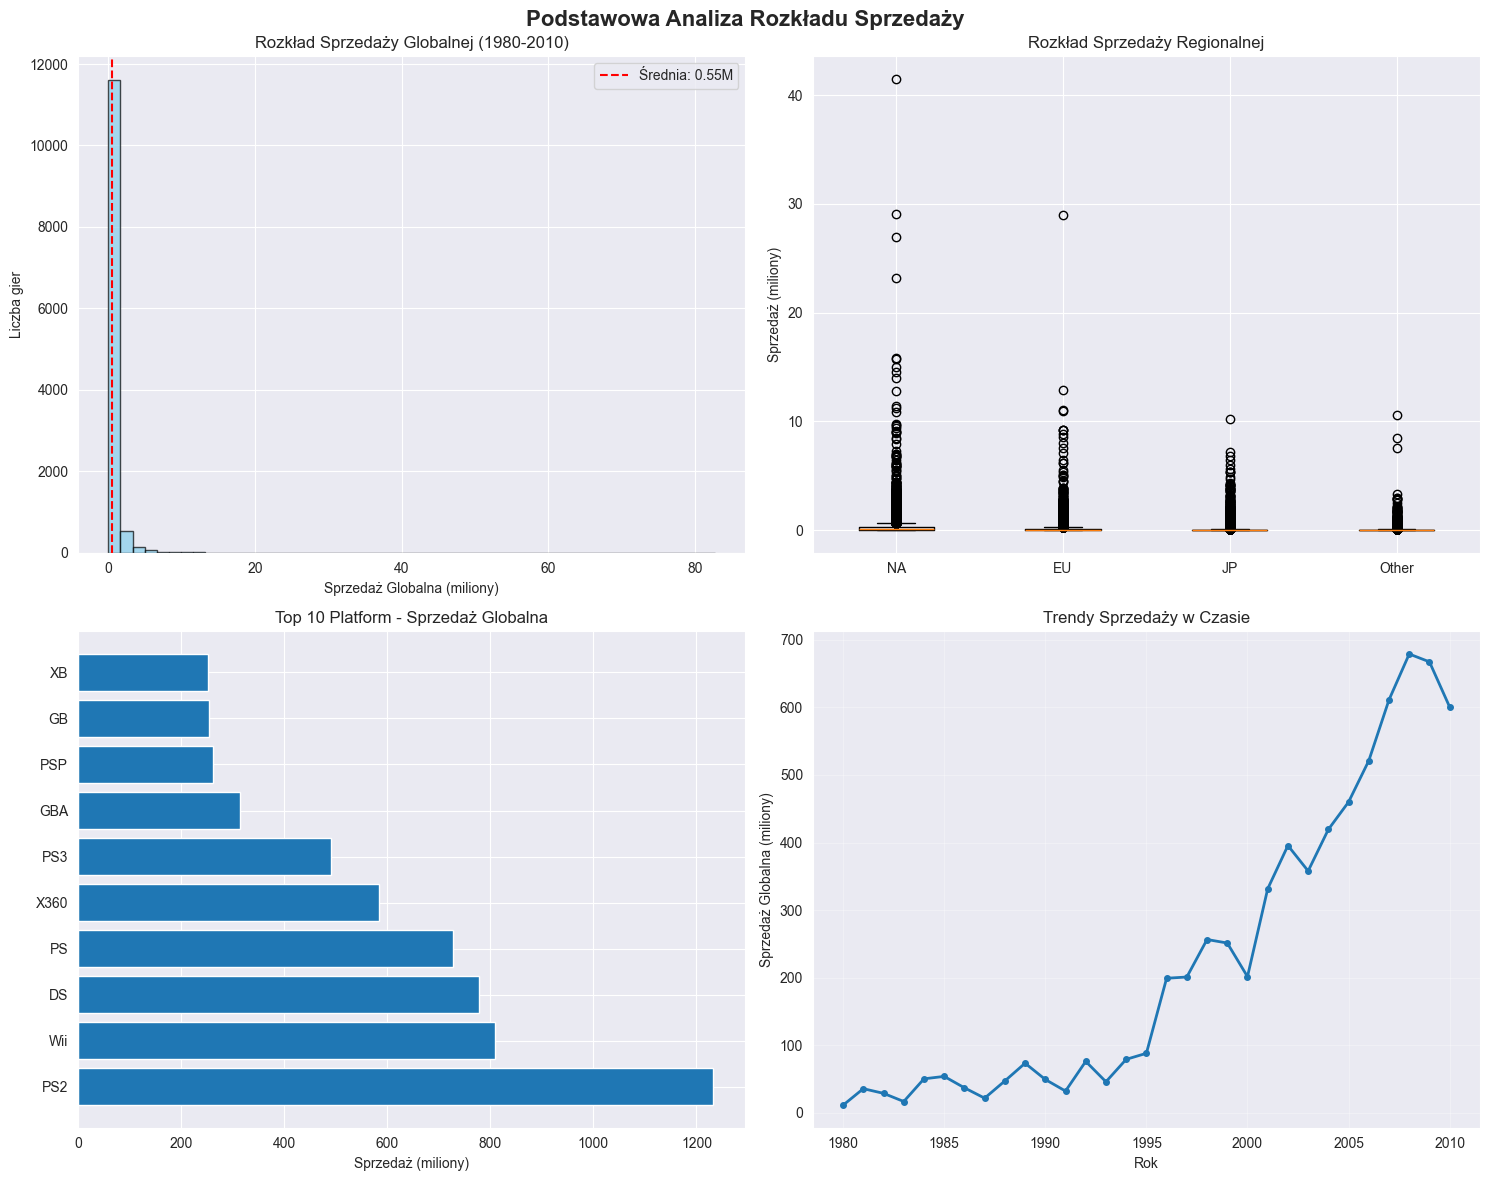

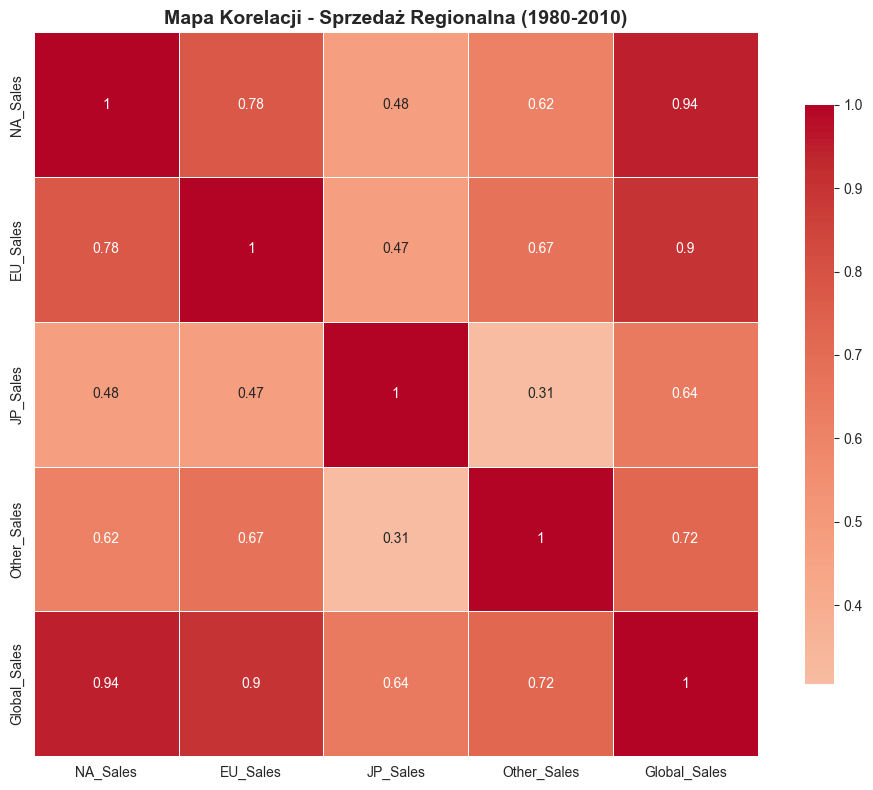


🏆 TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010):

2000:
   1. Pokémon Crystal Version (GB): 6.39M
   2. Final Fantasy IX (PS): 5.3M
   3. Driver 2 (PS): 4.73M

2001:
   1. Gran Turismo 3: A-Spec (PS2): 14.98M
   2. Grand Theft Auto III (PS2): 13.1M
   3. Final Fantasy X (PS2): 8.05M

2002:
   1. Grand Theft Auto: Vice City (PS2): 16.15M
   2. Pokemon Ruby/Pokemon Sapphire (GBA): 15.85M
   3. Medal of Honor: Frontline (PS2): 6.83M

2003:
   1. Need for Speed Underground (PS2): 7.2M
   2. Mario Kart: Double Dash!! (GC): 6.95M
   3. Final Fantasy X-2 (PS2): 5.29M

2004:
   1. Grand Theft Auto: San Andreas (PS2): 20.81M
   2. Gran Turismo 4 (PS2): 11.66M
   3. Pokemon FireRed/Pokemon LeafGreen (GBA): 10.49M

2005:
   1. Nintendogs (DS): 24.76M
   2. Mario Kart DS (DS): 23.42M
   3. Brain Age: Train Your Brain in Minutes a Day (DS): 20.22M

2006:
   1. Wii Sports (Wii): 82.74M
   2. New Super Mario Bros. (DS): 30.01M
   3. Wii Play (Wii): 29.02M

2007:
   1. Wii Fit (Wii): 22.72M
   2. Halo

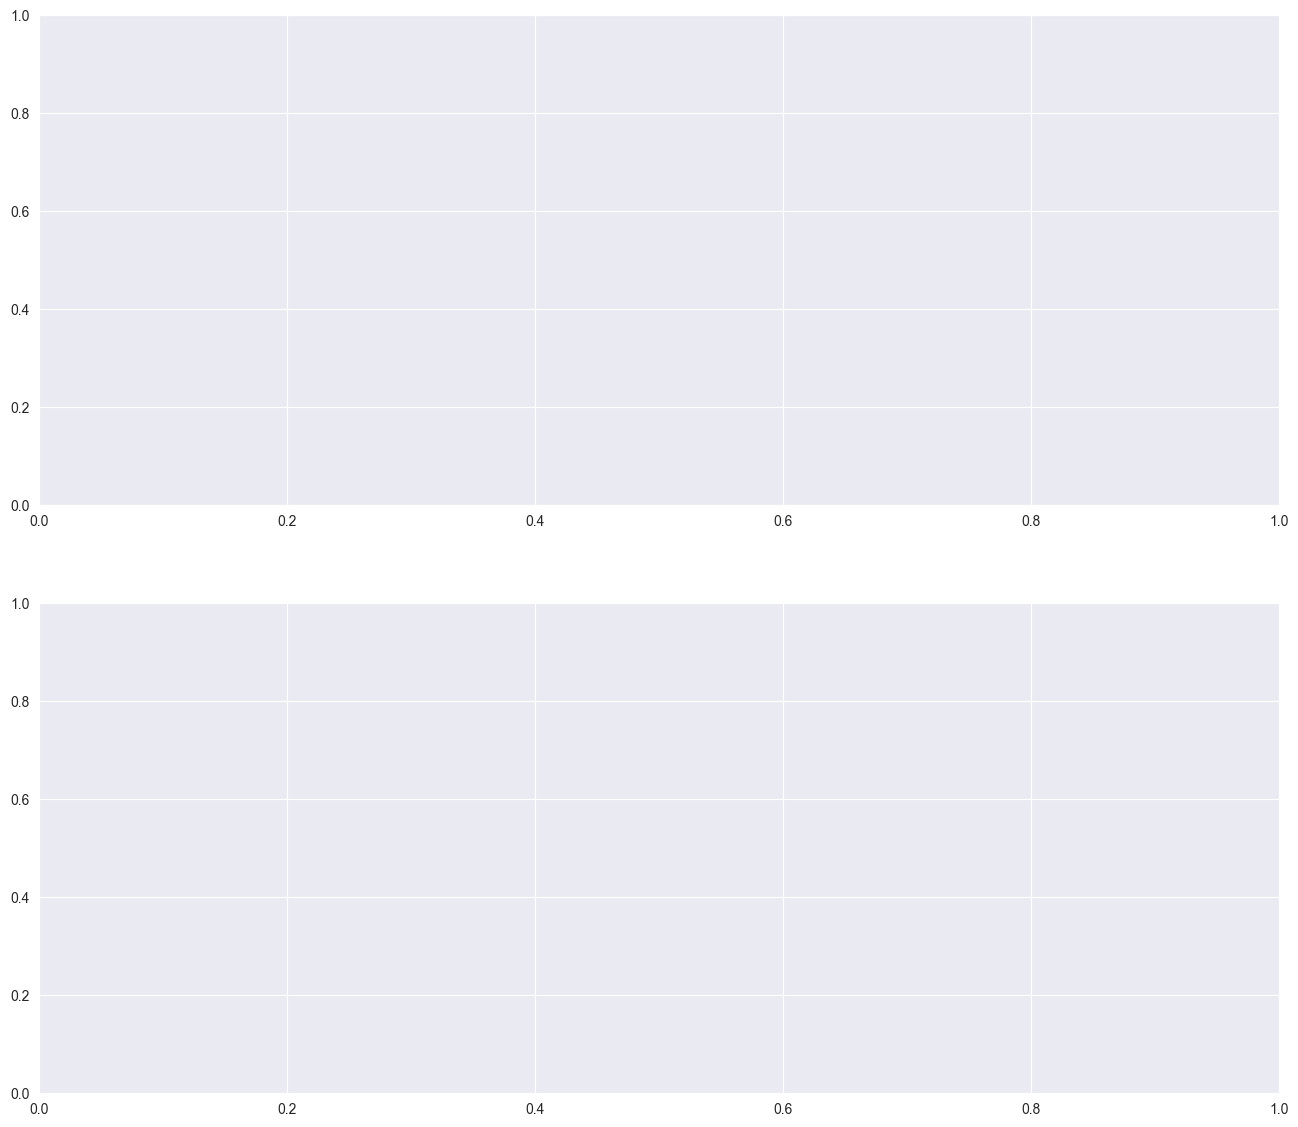

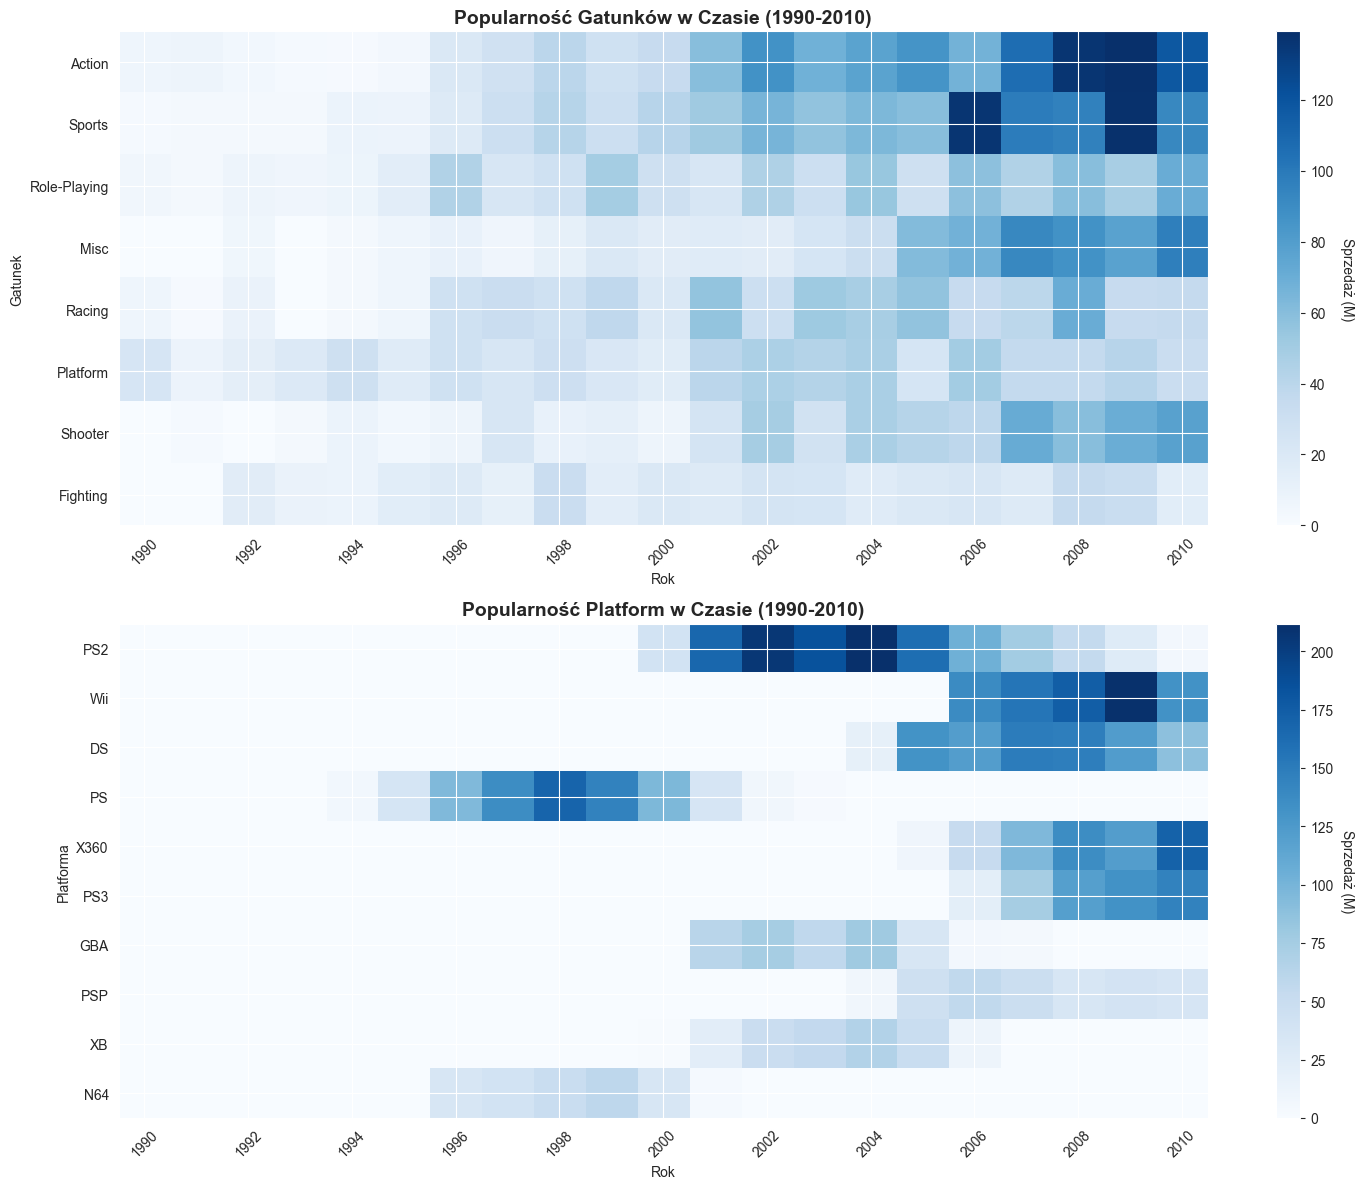

C:\Users\karol\AppData\Local\Temp\ipykernel_27552\2444938894.py:187: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
D:\PycharmProjects\pythonProject3\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


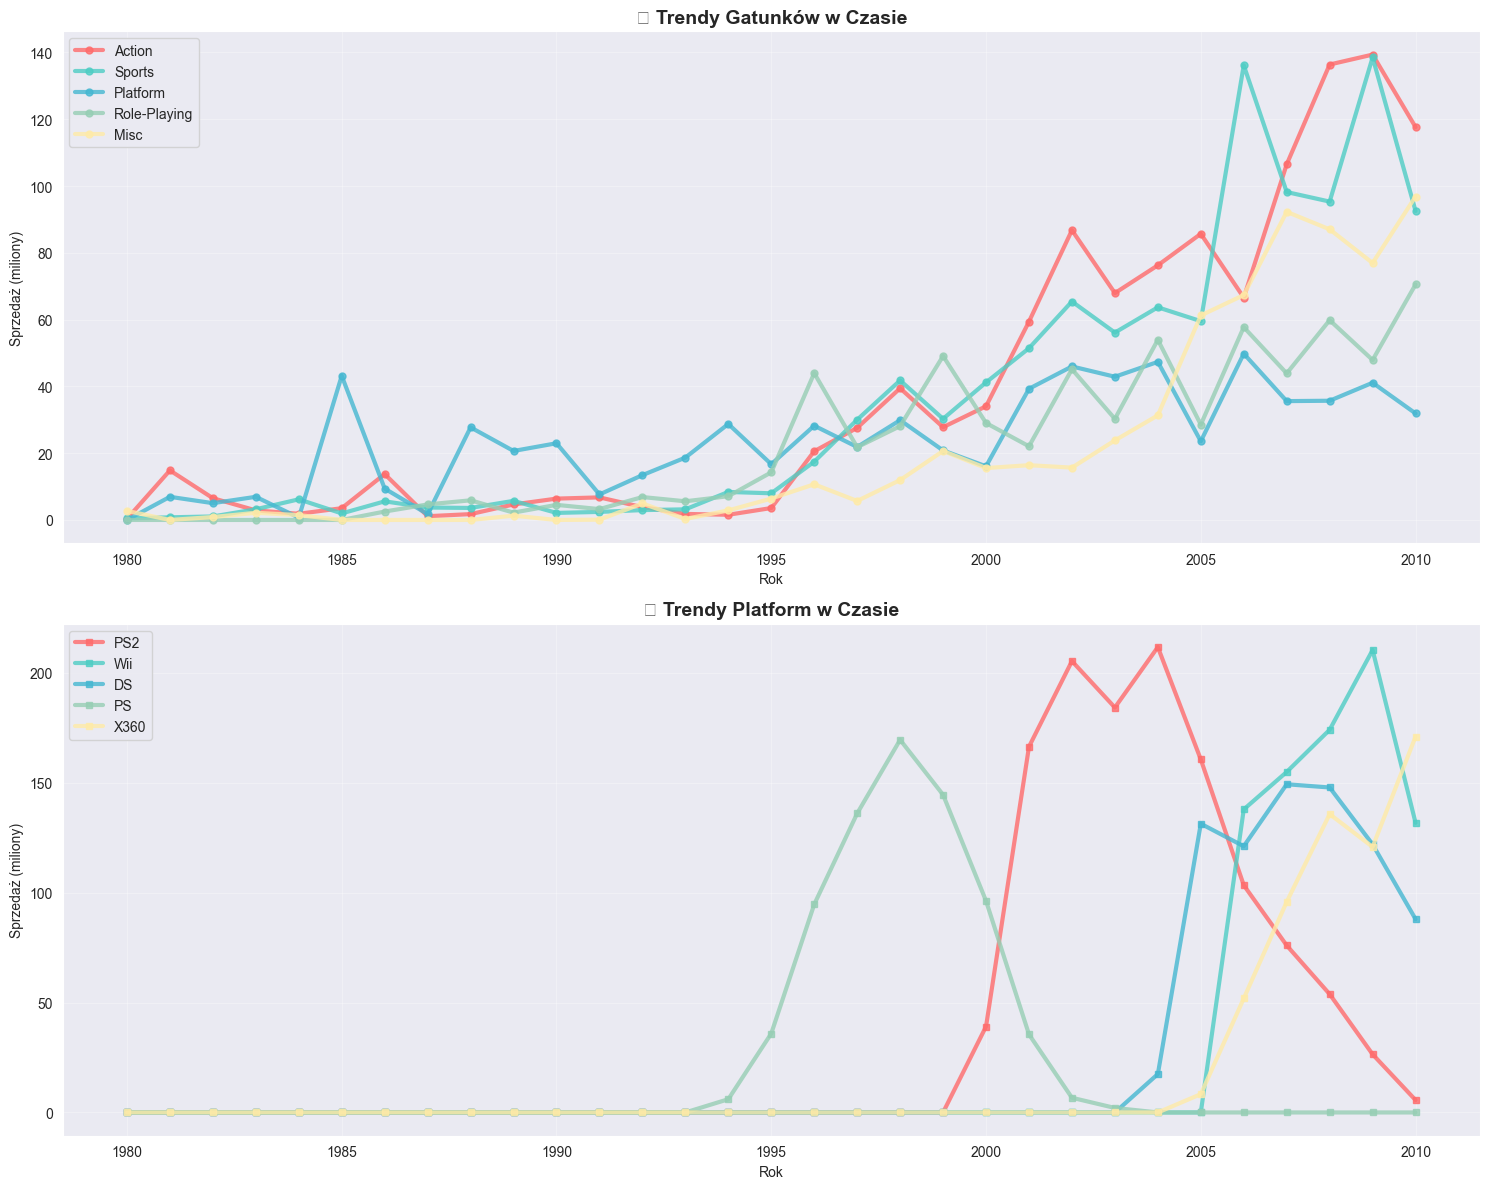

In [16]:
# ============================================================================
# 7. PODSTAWOWE WIZUALIZACJE ROZPOZNAWCZE
# ============================================================================

print("\n\n7. TWORZENIE WIZUALIZACJI NA DANYCH WYSOKIEJ JAKOŚCI")
print("-" * 50)

# KLUCZOWE: Używamy danych wysokiej jakości (1980-2010) zamiast całego datasetu
print("🎯 UWAGA: Wszystkie wizualizacje używają danych wysokiej jakości (1980-2010)")
cutoff_year = 2010
df_quality = df[df['Year'] <= cutoff_year].copy()

print(f"📊 Porównanie zakresów danych:")
print(f"   • Cały dataset: {len(df):,} gier ({df['Year'].min():.0f}-{df['Year'].max():.0f})")
print(f"   • Wysoka jakość: {len(df_quality):,} gier ({df_quality['Year'].min():.0f}-{df_quality['Year'].max():.0f})")
print(f"   • Redukcja: {len(df) - len(df_quality):,} gier ({(len(df) - len(df_quality))/len(df)*100:.1f}%)")

# Ustawienie rozmiaru figur
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Rozkład sprzedaży globalnej
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Podstawowa Analiza Rozkładu Sprzedaży', fontsize=16, fontweight='bold')

# Histogram sprzedaży globalnej
axes[0,0].hist(df_quality['Global_Sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Rozkład Sprzedaży Globalnej (1980-2010)')
axes[0,0].set_xlabel('Sprzedaż Globalna (miliony)')
axes[0,0].set_ylabel('Liczba gier')
axes[0,0].axvline(df_quality['Global_Sales'].mean(), color='red', linestyle='--', 
                  label=f'Średnia: {df_quality["Global_Sales"].mean():.2f}M')
axes[0,0].legend()

# Box plot sprzedaży regionalnej
regional_data = df_quality[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
axes[0,1].boxplot([regional_data[col] for col in regional_data.columns], 
                  labels=[col.replace('_Sales', '') for col in regional_data.columns])
axes[0,1].set_title('Rozkład Sprzedaży Regionalnej')
axes[0,1].set_ylabel('Sprzedaż (miliony)')

# Top 10 platform
platform_sales_quality = df_quality.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=False)
top_platforms = platform_sales_quality.head(10)
axes[1,0].barh(range(len(top_platforms)), top_platforms['Global_Sales'])
axes[1,0].set_yticks(range(len(top_platforms)))
axes[1,0].set_yticklabels(top_platforms.index)
axes[1,0].set_title('Top 10 Platform - Sprzedaż Globalna')
axes[1,0].set_xlabel('Sprzedaż (miliony)')

# Sprzedaż w czasie
yearly_sales = df_quality.groupby('Year')['Global_Sales'].sum()
axes[1,1].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=2, markersize=4)
axes[1,1].set_title('Trendy Sprzedaży w Czasie')
axes[1,1].set_xlabel('Rok')
axes[1,1].set_ylabel('Sprzedaż Globalna (miliony)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Mapa korelacji
plt.figure(figsize=(10, 8))
correlation_matrix = df_quality[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Mapa Korelacji - Sprzedaż Regionalna (1980-2010)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 3. TOP GIRY W POSZCZEGÓLNYCH LATACH - jak prosił użytkownik
print("\n🏆 TOP GIRY W POSZCZEGÓLNYCH LATACH (2000-2010):")
for year in range(2000, 2011):
    year_games = df_quality[df_quality['Year'] == year].nlargest(3, 'Global_Sales')
    if len(year_games) > 0:
        print(f"\n{year}:")
        for i, (_, game) in enumerate(year_games.iterrows(), 1):
            print(f"   {i}. {game['Name']} ({game['Platform']}): {game['Global_Sales']}M")

print(f"\n📊 Tworzenie ulepszonych map czasowych popularności...")

# Przygotowanie danych dla map czasowych (1995-2010 dla lepszej czytelności)
time_df = df_quality[(df_quality['Year'] >= 1995) & (df_quality['Year'] <= 2010)].copy()

fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# 4. MAPA CZASOWA POPULARNOŚCI - ORYGINALNE KOLORY + półroczna granulacja
print(f"\n📊 Tworzenie map czasowych popularności...")

# Przygotowanie danych z półroczną granulacją (lepsza niż roczna)
time_df = df_quality[(df_quality['Year'] >= 1990) & (df_quality['Year'] <= 2010)].copy()

# Utworzenie półrocznych okresów dla lepszej granulacji
time_df['HalfYear'] = time_df['Year'] + (0.5 * ((time_df['Year'].astype(int) % 2)))
time_df['Period'] = time_df['Year'].astype(int).astype(str) + 'H' + ((time_df['Year'].astype(int) % 2) + 1).astype(str)

fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Mapa popularności gatunków w czasie - ORYGINALNE USTAWIENIA
genre_time = time_df.groupby(['Year', 'Genre'])['Global_Sales'].sum().unstack(fill_value=0)
# Wybieramy top 8 gatunków dla czytelności
top_genres = time_df.groupby('Genre')['Global_Sales'].sum().nlargest(8).index
genre_time_top = genre_time[top_genres]

# POWRÓT DO ORYGINALNEJ HEATMAPY
im1 = axes[0].imshow(genre_time_top.T, cmap='Blues', aspect='auto')
axes[0].set_title('Popularność Gatunków w Czasie (1990-2010)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rok')
axes[0].set_ylabel('Gatunek')

# Lepsze etykiety czasowe - co rok ale czytelnie
years_labels = range(1990, 2011, 2)  # co 2 lata
axes[0].set_xticks(range(0, len(genre_time_top.index), 2))
axes[0].set_xticklabels([str(int(year)) for year in genre_time_top.index[::2]], rotation=45)
axes[0].set_yticks(range(len(top_genres)))
axes[0].set_yticklabels(top_genres)

# Colorbar dla gatunków - ORYGINALNY
cbar1 = plt.colorbar(im1, ax=axes[0])
cbar1.set_label('Sprzedaż (M)', rotation=270, labelpad=15)

# Platformy w czasie - ORYGINALNE USTAWIENIA  
platform_time = time_df.groupby(['Year', 'Platform'])['Global_Sales'].sum().unstack(fill_value=0)
# Wybieramy top 10 platform dla czytelności
top_platforms = time_df.groupby('Platform')['Global_Sales'].sum().nlargest(10).index
platform_time_top = platform_time[top_platforms]

# POWRÓT DO ORYGINALNEJ HEATMAPY
im2 = axes[1].imshow(platform_time_top.T, cmap='Blues', aspect='auto')
axes[1].set_title('Popularność Platform w Czasie (1990-2010)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rok') 
axes[1].set_ylabel('Platforma')

# Te same etykiety czasowe
axes[1].set_xticks(range(0, len(platform_time_top.index), 2))
axes[1].set_xticklabels([str(int(year)) for year in platform_time_top.index[::2]], rotation=45)
axes[1].set_yticks(range(len(top_platforms)))
axes[1].set_yticklabels(top_platforms)

# Colorbar dla platform - ORYGINALNY
cbar2 = plt.colorbar(im2, ax=axes[1])
cbar2.set_label('Sprzedaż (M)', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()
# ALTERNATYWA - wykresy liniowe z lepszą granulacją czasową
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# === GATUNKI - LINIE CZASOWE ===
yearly_genre = df_quality.groupby(['Year', 'Genre'])['Global_Sales'].sum().unstack(fill_value=0)
top_5_genres = df_quality.groupby('Genre')['Global_Sales'].sum().nlargest(5).index

colors_genre = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for i, genre in enumerate(top_5_genres):
    if genre in yearly_genre.columns:
        ax1.plot(yearly_genre.index, yearly_genre[genre], 
                marker='o', linewidth=3, markersize=5, 
                label=genre, color=colors_genre[i], alpha=0.8)

ax1.set_title('📈 Trendy Gatunków w Czasie', fontsize=14, fontweight='bold')
ax1.set_xlabel('Rok')
ax1.set_ylabel('Sprzedaż (miliony)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# === PLATFORMY - LINIE CZASOWE ===
yearly_platform = df_quality.groupby(['Year', 'Platform'])['Global_Sales'].sum().unstack(fill_value=0)
top_5_platforms = df_quality.groupby('Platform')['Global_Sales'].sum().nlargest(5).index

colors_platform = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

for i, platform in enumerate(top_5_platforms):
    if platform in yearly_platform.columns:
        ax2.plot(yearly_platform.index, yearly_platform[platform], 
                marker='s', linewidth=3, markersize=5, 
                label=platform, color=colors_platform[i], alpha=0.8)

ax2.set_title('📈 Trendy Platform w Czasie', fontsize=14, fontweight='bold')
ax2.set_xlabel('Rok')
ax2.set_ylabel('Sprzedaż (miliony)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:

# ============================================================================
# 8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY
# ============================================================================

print("\n\n8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY")
print("-" * 50)

# Tworzenie kopii danych do oczyszczenia
df_clean = df.copy()

print("🧹 Rozpoczęcie procesu oczyszczania...")

# 1. Usunięcie gier z zerową sprzedażą
initial_count = len(df_clean)
df_clean = df_clean[df_clean['Global_Sales'] > 0]
removed_zero = initial_count - len(df_clean)
print(f"   ✓ Usunięto {removed_zero} gier z zerową sprzedażą")

# 2. Korekta niespójności w sumowaniu (opcjonalne - tutaj tylko flagowanie)
df_clean['Sales_Consistent'] = np.abs(
    (df_clean['NA_Sales'] + df_clean['EU_Sales'] + 
     df_clean['JP_Sales'] + df_clean['Other_Sales']) - df_clean['Global_Sales']
) <= 0.01

inconsistent_count = (~df_clean['Sales_Consistent']).sum()
print(f"   ⚠️  Flagowanie {inconsistent_count} niespójnych rekordów")

# 3. Dodanie kategorii dekad - POPRAWKA błędu z NaN
df_clean['Decade'] = df_clean['Year'].fillna(0)  # Wypełnij NaN zerami tymczasowo
df_clean['Decade'] = (df_clean['Decade'] // 10 * 10).astype(int)
df_clean.loc[df_clean['Year'].isna(), 'Decade'] = np.nan  # Przywróć NaN gdzie był Year = NaN
print(f"   ✓ Dodano kategorię dekad (obsłużono NaN)")

# 4. Dodanie kategorii sukcesu
df_clean['Success_Category'] = pd.cut(df_clean['Global_Sales'], 
                                     bins=[0, 1, 5, 10, 50, float('inf')],
                                     labels=['Low', 'Medium', 'High', 'Very High', 'Blockbuster'])
print(f"   ✓ Dodano kategorię sukcesu sprzedażowego")

# 5. Dodanie udziału regionalnego
df_clean['NA_Share'] = df_clean['NA_Sales'] / df_clean['Global_Sales'] * 100
df_clean['EU_Share'] = df_clean['EU_Sales'] / df_clean['Global_Sales'] * 100
df_clean['JP_Share'] = df_clean['JP_Sales'] / df_clean['Global_Sales'] * 100
df_clean['Other_Share'] = df_clean['Other_Sales'] / df_clean['Global_Sales'] * 100
print(f"   ✓ Dodano udziały sprzedaży regionalnej")

# 6. Standaryzacja nazw platform (grupowanie podobnych)
platform_mapping = {
    'PS': 'PlayStation', 'PS2': 'PlayStation', 'PS3': 'PlayStation', 'PS4': 'PlayStation',
    'PSP': 'PlayStation Portable', 'PSV': 'PlayStation Portable',
    'X360': 'Xbox', 'XB': 'Xbox', 'XOne': 'Xbox',
    'Wii': 'Nintendo Console', 'WiiU': 'Nintendo Console', 'NES': 'Nintendo Console', 
    'SNES': 'Nintendo Console', 'N64': 'Nintendo Console', 'GC': 'Nintendo Console',
    'GB': 'Nintendo Handheld', 'GBA': 'Nintendo Handheld', 'DS': 'Nintendo Handheld', '3DS': 'Nintendo Handheld'
}

df_clean['Platform_Family'] = df_clean['Platform'].map(platform_mapping).fillna('Other')
print(f"   ✓ Zgrupowano platformy w rodziny")

# Podsumowanie oczyszczonych danych
print(f"\n📊 Podsumowanie oczyszczonych danych:")
print(f"   • Oryginalne rekordy: {len(df):,}")
print(f"   • Oczyszczone rekordy: {len(df_clean):,}")
print(f"   • Usunięte rekordy: {len(df) - len(df_clean):,}")
print(f"   • Nowe kolumny: {len(df_clean.columns) - len(df.columns)}")
print(f"   • ZACHOWANO wszystkie gry topowe i historyczne")
print(f"   • Utworzono kategorię sukcesu zamiast usuwania outlierów")

# Dodatkowe podsumowanie według zakresu czasowego
cutoff_year = 2010  # Na podstawie analizy z pkt 2.5
quality_data = df_clean[df_clean['Year'] <= cutoff_year]
print(f"\n🎯 Dane wysokiej jakości (1980-{cutoff_year}):")
print(f"   • Rekordy w zakresie HQ: {len(quality_data):,}")
print(f"   • Procent datasetu: {(len(quality_data)/len(df_clean)*100):.1f}%")
print(f"   • Rekomendacja: użyć tego zakresu dla kluczowych analiz")



8. PRZYGOTOWANIE DANYCH DO DALSZEJ ANALIZY
--------------------------------------------------
🧹 Rozpoczęcie procesu oczyszczania...
   ✓ Usunięto 0 gier z zerową sprzedażą
   ⚠️  Flagowanie 2625 niespójnych rekordów
   ✓ Dodano kategorię dekad (obsłużono NaN)
   ✓ Dodano kategorię sukcesu sprzedażowego
   ✓ Dodano udziały sprzedaży regionalnej
   ✓ Zgrupowano platformy w rodziny

📊 Podsumowanie oczyszczonych danych:
   • Oryginalne rekordy: 16,598
   • Oczyszczone rekordy: 16,598
   • Usunięte rekordy: 0
   • Nowe kolumny: 8
   • ZACHOWANO wszystkie gry topowe i historyczne
   • Utworzono kategorię sukcesu zamiast usuwania outlierów

🎯 Dane wysokiej jakości (1980-2010):
   • Rekordy w zakresie HQ: 12,441
   • Procent datasetu: 75.0%
   • Rekomendacja: użyć tego zakresu dla kluczowych analiz


In [18]:

print(f"\n\n8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH")
print("-" * 60)

print(f"📊 Porównanie trzech wersji danych:")
print(f"   • df (oryginalny): {len(df):,} rekordów")
print(f"   • df_quality (1980-2010): {len(df_quality):,} rekordów") 
print(f"   • df_clean (oczyszczony): {len(df_clean):,} rekordów")

# Analiza nowych kolumn w df_clean
print(f"\n🔍 Analiza nowych kolumn:")

# Kategorie sukcesu
success_dist = df_clean['Success_Category'].value_counts()
print(f"   • Kategorie sukcesu:")
for category, count in success_dist.items():
    percentage = (count / len(df_clean)) * 100
    print(f"     - {category}: {count:,} gier ({percentage:.1f}%)")

# Rodziny platform
platform_family_dist = df_clean['Platform_Family'].value_counts()
print(f"\n   • Rodziny platform:")
for family, count in platform_family_dist.head(5).items():
    percentage = (count / len(df_clean)) * 100
    print(f"     - {family}: {count:,} gier ({percentage:.1f}%)")

# Analiza udziałów regionalnych
print(f"\n   • Średnie udziały regionalne:")
print(f"     - NA: {df_clean['NA_Share'].mean():.1f}%")
print(f"     - EU: {df_clean['EU_Share'].mean():.1f}%") 
print(f"     - JP: {df_clean['JP_Share'].mean():.1f}%")
print(f"     - Other: {df_clean['Other_Share'].mean():.1f}%")

# Przykłady gier z różnych kategorii sukcesu
print(f"\n🎯 Przykłady z każdej kategorii sukcesu:")
for category in ['Blockbuster', 'Hit', 'Successful', 'Standard', 'Niche']:
    examples = df_clean[df_clean['Success_Category'] == category].nlargest(2, 'Global_Sales')
    if len(examples) > 0:
        print(f"   • {category}:")
        for _, game in examples.iterrows():
            print(f"     - {game['Name']} ({game['Platform']}): {game['Global_Sales']}M")

# Rekomendacje do dalszej analizy
print(f"\n💡 REKOMENDACJE UŻYCIA RÓŻNYCH WERSJI:")
print(f"   • df_quality (1980-2010): główne analizy trendów i wzorców")
print(f"   • df_clean: modelowanie ML i segmentacja")
print(f"   • df (pełny): kontekst historyczny i completeness check")



8.1. SZCZEGÓŁOWA ANALIZA OCZYSZCZONYCH DANYCH
------------------------------------------------------------
📊 Porównanie trzech wersji danych:
   • df (oryginalny): 16,598 rekordów
   • df_quality (1980-2010): 12,441 rekordów
   • df_clean (oczyszczony): 16,598 rekordów

🔍 Analiza nowych kolumn:
   • Kategorie sukcesu:
     - Low: 14,544 gier (87.6%)
     - Medium: 1,849 gier (11.1%)
     - High: 143 gier (0.9%)
     - Very High: 61 gier (0.4%)
     - Blockbuster: 1 gier (0.0%)

   • Rodziny platform:
     - PlayStation: 5,022 gier (30.3%)
     - Nintendo Handheld: 3,592 gier (21.6%)
     - Nintendo Console: 2,680 gier (16.1%)
     - Xbox: 2,302 gier (13.9%)
     - PlayStation Portable: 1,626 gier (9.8%)

   • Średnie udziały regionalne:
     - NA: 45.6%
     - EU: 22.9%
     - JP: 24.2%
     - Other: 6.5%

🎯 Przykłady z każdej kategorii sukcesu:
   • Blockbuster:
     - Wii Sports (Wii): 82.74M

💡 REKOMENDACJE UŻYCIA RÓŻNYCH WERSJI:
   • df_quality (1980-2010): główne analizy trendów

In [19]:

# ============================================================================
# 9. EKSPORT OCZYSZCZONYCH DANYCH
# ============================================================================

print("\n\n9. EKSPORT OCZYSZCZONYCH DANYCH")
print("-" * 50)

# Zapisanie oczyszczonych danych
df_clean.to_csv('video_games_sales_cleaned.csv', index=False)
print(f"✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'")

# Zapisanie raportu jakości danych
quality_report = {
    'Original_Records': len(df),
    'Cleaned_Records': len(df_clean),
    'Removed_Records': len(df) - len(df_clean),
    'Missing_Data_Percent': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
    'Outliers_Percent': global_outliers['outliers_percent'],
    'Inconsistent_Sales': inconsistent_count
}

print(f"\n📋 Raport jakości danych:")
for key, value in quality_report.items():
    if 'Percent' in key:
        print(f"   • {key.replace('_', ' ')}: {value:.2f}%")
    else:
        print(f"   • {key.replace('_', ' ')}: {value:,}")



9. EKSPORT OCZYSZCZONYCH DANYCH
--------------------------------------------------
✅ Oczyszczone dane zapisane jako 'video_games_sales_cleaned.csv'

📋 Raport jakości danych:
   • Original Records: 16,598
   • Cleaned Records: 16,598
   • Removed Records: 0
   • Missing Data Percent: 0.18%
   • Outliers Percent: 11.40%
   • Inconsistent Sales: 2,625


In [20]:

# ============================================================================
# 10. REKOMENDACJE DLA DALSZEJ ANALIZY
# ============================================================================

print("\n\n10. REKOMENDACJE DLA DALSZEJ ANALIZY")
print("-" * 50)

recommendations = [
    "🔍 **PRIORYTET**: Analiza 'Golden Age' (2006-2009) - dlaczego był szczyt sprzedaży?",
    "🎮 Głęboka analiza strategii Nintendo w erze Wii - case study innowacji",
    "📈 Modelowanie cykli życia platform - przewidywanie kolejnych przejść",
    "🌍 Analiza różnic preferencji regionalnych - szczególnie JP vs NA/EU", 
    "⏰ Badanie wpływu motion control na rewolucję w gatunkach (Sports boom)",
    "📊 Tworzenie interaktywnego dashboardu z focus na trendy czasowe",
    "🤖 ML: Przewidywanie sukcesu na podstawie timing + platform + genre",
    "📉 Analiza przyczyn spadku post-2010 (digitalizacja vs braki danych)",
    "🔬 Segmentacja: era pre-digital (do 2010) vs era digital (po 2010)",
    "🎯 Case studies: Analiza fenomenów (Wii Sports, Pokemon, GTA series)"
]

print("Następne kroki w projekcie - ZAKTUALIZOWANE:")
for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print(f"\n🏆 NAJWAŻNIEJSZE ODKRYCIA DO PREZENTACJI:")
key_findings = [
    "'Golden Age' 2006-2009: szczyt branży, wzrost sprzedaży o >150%",
    "Nintendo jako disruptor: zdominowało rynek dzięki innowacjom",
    "Motion control rewolucja: Sports games boom w erze Wii",
    "Ewolucja gatunków: Platform → Action jako dominujący",
    "Cykle życia platform: skracanie się w czasie (tech acceleration)",
    "Regionalne różnice: kultura wpływa na preferencje gatunków",
    "Spadek post-2010: konieczność analizy digitalizacji rynku"
]

for i, finding in enumerate(key_findings, 1):
    print(f"   {i}. {finding}")

print("\n" + "=" * 80)
print("ANALIZA WSTĘPNA ZAKOŃCZONA POMYŚLNIE!")
print("Dane gotowe do zaawansowanej analizy i modelowania.")
print("=" * 80)



10. REKOMENDACJE DLA DALSZEJ ANALIZY
--------------------------------------------------
Następne kroki w projekcie - ZAKTUALIZOWANE:
   1. 🔍 **PRIORYTET**: Analiza 'Golden Age' (2006-2009) - dlaczego był szczyt sprzedaży?
   2. 🎮 Głęboka analiza strategii Nintendo w erze Wii - case study innowacji
   3. 📈 Modelowanie cykli życia platform - przewidywanie kolejnych przejść
   4. 🌍 Analiza różnic preferencji regionalnych - szczególnie JP vs NA/EU
   5. ⏰ Badanie wpływu motion control na rewolucję w gatunkach (Sports boom)
   6. 📊 Tworzenie interaktywnego dashboardu z focus na trendy czasowe
   7. 🤖 ML: Przewidywanie sukcesu na podstawie timing + platform + genre
   8. 📉 Analiza przyczyn spadku post-2010 (digitalizacja vs braki danych)
   9. 🔬 Segmentacja: era pre-digital (do 2010) vs era digital (po 2010)
   10. 🎯 Case studies: Analiza fenomenów (Wii Sports, Pokemon, GTA series)

🏆 NAJWAŻNIEJSZE ODKRYCIA DO PREZENTACJI:
   1. 'Golden Age' 2006-2009: szczyt branży, wzrost sprzedaży o >15

In [21]:

# ============================================================================
# 10. REKOMENDACJE DLA DALSZEJ ANALIZY
# ============================================================================

print("\n\n10. REKOMENDACJE DLA DALSZEJ ANALIZY")
print("-" * 50)

recommendations = [
    "🔍 Analiza segmentacji rynku przy użyciu algorytmów klastrowania",
    "📈 Modelowanie predykcyjne sukcesu gier na podstawie cech",
    "🌍 Analiza różnic preferencji między regionami geograficznymi", 
    "⏰ Badanie cykli życia platform i ewolucji gatunków",
    "🎯 Identyfikacja czynników wpływających na sukces wydawców",
    "📊 Tworzenie interaktywnego dashboardu do eksploracji danych",
    "🤖 Zastosowanie algorytmów ML do przewidywania sprzedaży",
    "📉 Analiza trendów i prognozowanie przyszłego rozwoju rynku"
]

print("Następne kroki w projekcie:")
for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print("\n" + "=" * 80)
print("ANALIZA WSTĘPNA ZAKOŃCZONA POMYŚLNIE!")
print("Dane gotowe do zaawansowanej analizy i modelowania.")
print("=" * 80)



10. REKOMENDACJE DLA DALSZEJ ANALIZY
--------------------------------------------------
Następne kroki w projekcie:
   1. 🔍 Analiza segmentacji rynku przy użyciu algorytmów klastrowania
   2. 📈 Modelowanie predykcyjne sukcesu gier na podstawie cech
   3. 🌍 Analiza różnic preferencji między regionami geograficznymi
   4. ⏰ Badanie cykli życia platform i ewolucji gatunków
   5. 🎯 Identyfikacja czynników wpływających na sukces wydawców
   6. 📊 Tworzenie interaktywnego dashboardu do eksploracji danych
   7. 🤖 Zastosowanie algorytmów ML do przewidywania sprzedaży
   8. 📉 Analiza trendów i prognozowanie przyszłego rozwoju rynku

ANALIZA WSTĘPNA ZAKOŃCZONA POMYŚLNIE!
Dane gotowe do zaawansowanej analizy i modelowania.


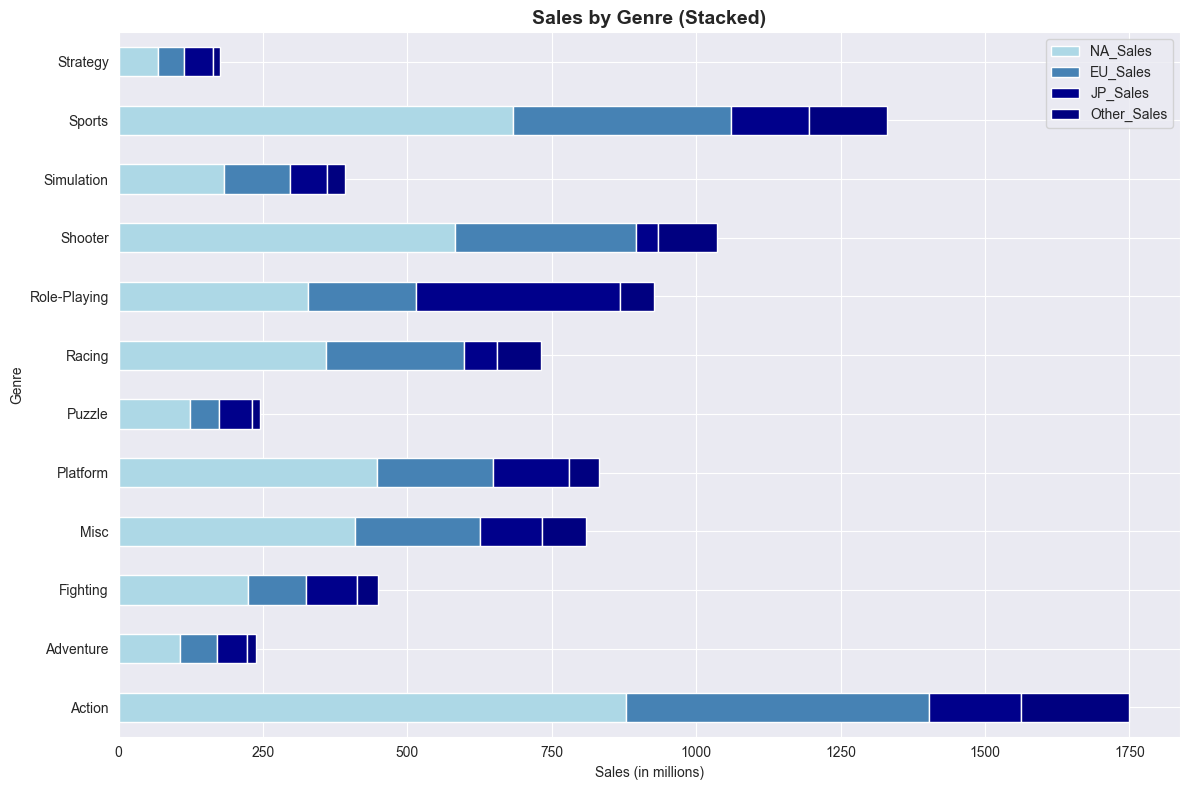

In [22]:
# Grupowanie sprzedaży według gatunków
genre_sales = df.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].sum()

# Wykres poziomy stacked bar
fig, ax = plt.subplots(figsize=(12, 8))
genre_sales.plot(kind='barh', stacked=True, ax=ax, 
                 color=['lightblue', 'steelblue', 'darkblue', 'navy'])
ax.set_title('Sales by Genre (Stacked)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sales (in millions)')
plt.tight_layout()
plt.show()

C:\Users\karol\AppData\Local\Temp\ipykernel_27552\1424533929.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0,1].boxplot(box_data, labels=box_labels)


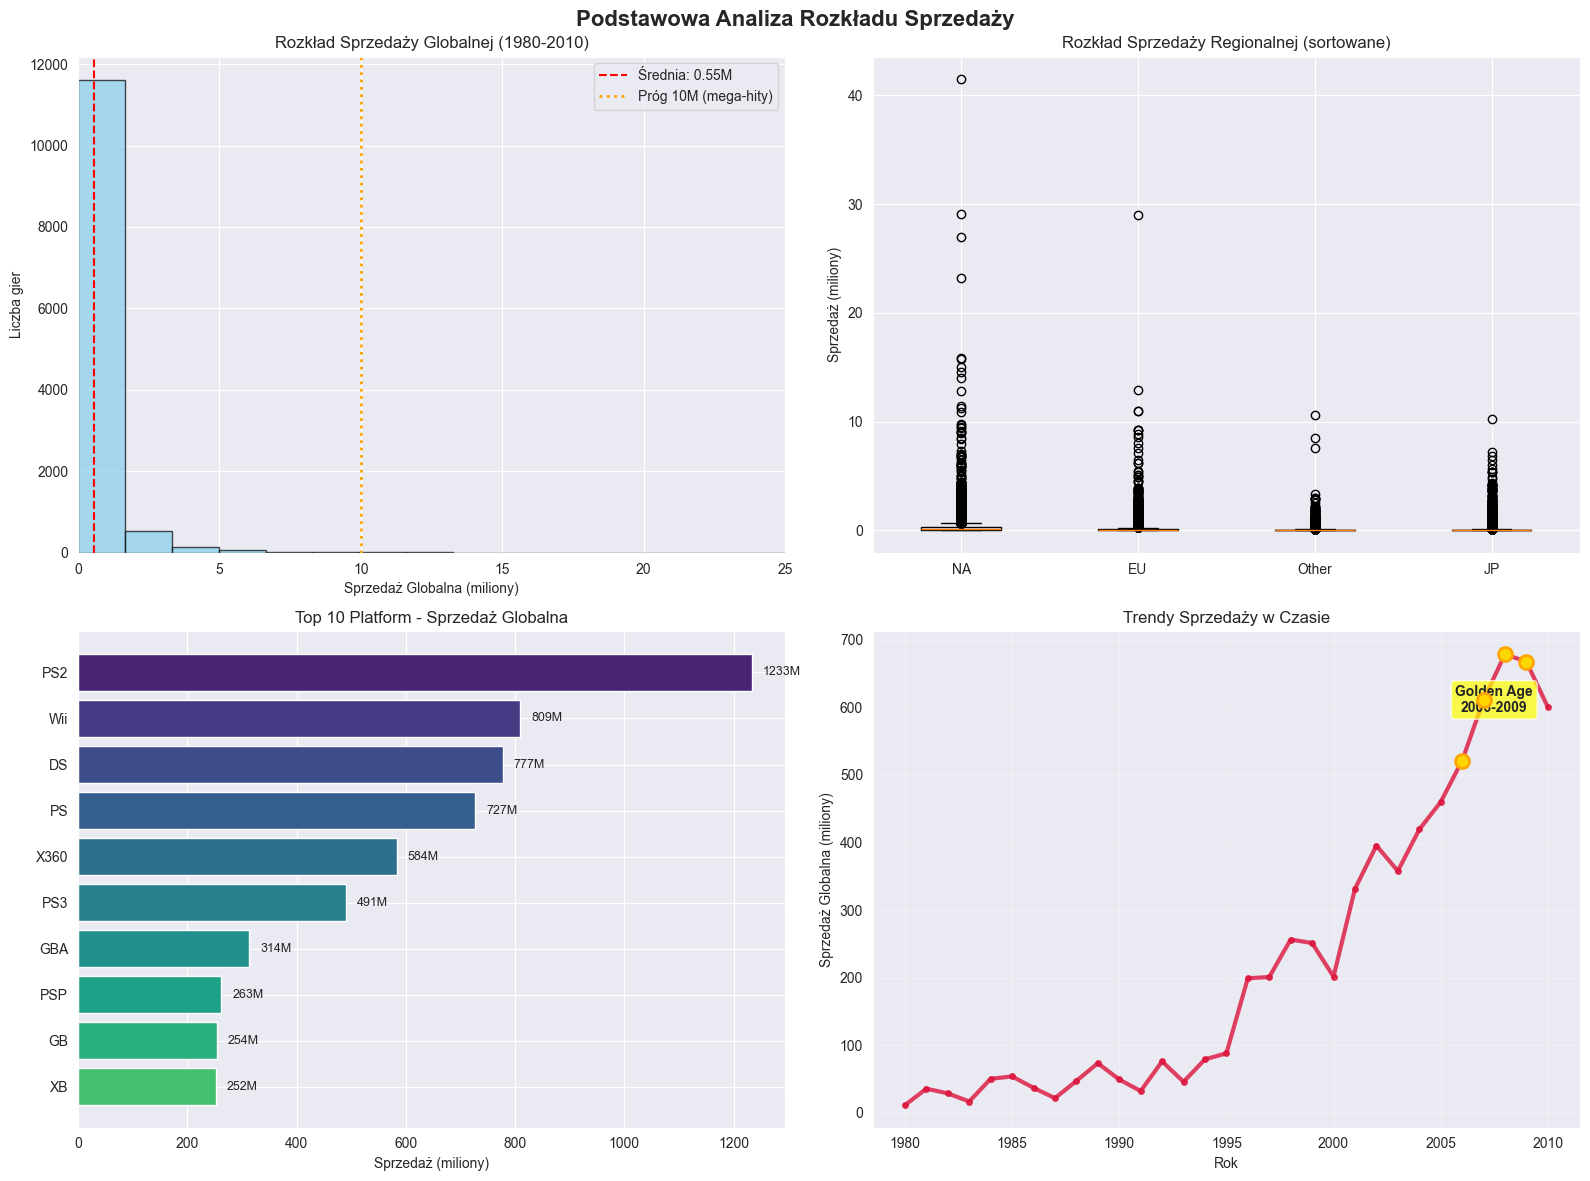

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Tworzenie figury z 4 subplotami
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Podstawowa Analiza Rozkładu Sprzedaży', fontsize=16, fontweight='bold')

# 1. Rozkład sprzedaży globalnej Z ODNOŚNIKIEM 10M
axes[0,0].hist(df_quality['Global_Sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Rozkład Sprzedaży Globalnej (1980-2010)')
axes[0,0].set_xlabel('Sprzedaż Globalna (miliony)')
axes[0,0].set_ylabel('Liczba gier')
axes[0,0].axvline(df_quality['Global_Sales'].mean(), color='red', linestyle='--', 
                  label=f'Średnia: {df_quality["Global_Sales"].mean():.2f}M')
# ODNOŚNIK 10M
axes[0,0].axvline(10, color='orange', linestyle=':', linewidth=2, 
                  label='Próg 10M (mega-hity)')
axes[0,0].legend()
axes[0,0].set_xlim(0, 25)  # Lepszy zoom

# 2. Box plot sprzedaży regionalnej - POSORTOWANE
regional_data = df_quality[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
# Sortowanie według mediany
region_medians = regional_data.median().sort_values(ascending=False)
sorted_regions = region_medians.index

box_data = [regional_data[col] for col in sorted_regions]
box_labels = [col.replace('_Sales', '') for col in sorted_regions]

bp = axes[0,1].boxplot(box_data, labels=box_labels)
axes[0,1].set_title('Rozkład Sprzedaży Regionalnej (sortowane)')
axes[0,1].set_ylabel('Sprzedaż (miliony)')

# 3. Top 10 platform - JUŻ POSORTOWANE, ale ładniejsze kolory
platform_sales_quality = df_quality.groupby('Platform').agg({
    'Global_Sales': 'sum',
    'Name': 'count'
}).rename(columns={'Name': 'Games_Count'}).sort_values('Global_Sales', ascending=True)  # ascending=True dla barh

top_platforms = platform_sales_quality.tail(10)  # ostatnie 10 = największe

# Gradient kolorów
colors = plt.cm.viridis_r(np.linspace(0.3, 0.9, len(top_platforms)))
bars = axes[1,0].barh(range(len(top_platforms)), top_platforms['Global_Sales'], color=colors)
axes[1,0].set_yticks(range(len(top_platforms)))
axes[1,0].set_yticklabels(top_platforms.index)
axes[1,0].set_title('Top 10 Platform - Sprzedaż Globalna')
axes[1,0].set_xlabel('Sprzedaż (miliony)')

# Dodanie wartości na końcu słupków
for i, (platform, sales) in enumerate(top_platforms['Global_Sales'].items()):
    axes[1,0].text(sales + 20, i, f'{sales:.0f}M', va='center', fontsize=9)

# 4. Trendy w czasie - ULEPSZONE
yearly_sales = df_quality.groupby('Year')['Global_Sales'].sum()
axes[1,1].plot(yearly_sales.index, yearly_sales.values, marker='o', linewidth=3, 
               markersize=4, color='crimson', alpha=0.8)
axes[1,1].set_title('Trendy Sprzedaży w Czasie')
axes[1,1].set_xlabel('Rok')
axes[1,1].set_ylabel('Sprzedaż Globalna (miliony)')
axes[1,1].grid(True, alpha=0.3)

# Oznaczenie Golden Age
golden_age_years = range(2006, 2010)
for year in golden_age_years:
    if year in yearly_sales.index:
        axes[1,1].scatter(year, yearly_sales[year], s=100, color='gold', 
                         edgecolor='orange', linewidth=2, zorder=5)

axes[1,1].text(2007.5, yearly_sales.max() * 0.9, 'Golden Age\n2006-2009', 
               ha='center', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

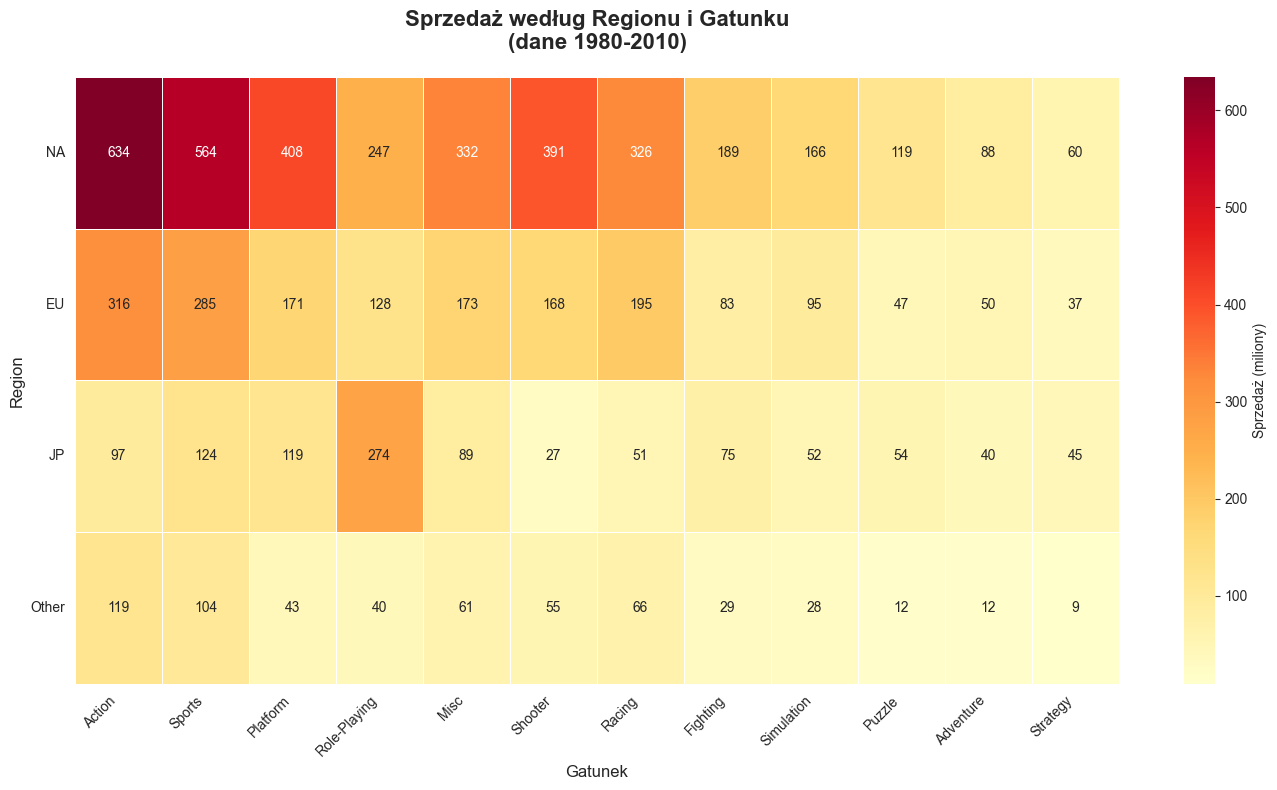

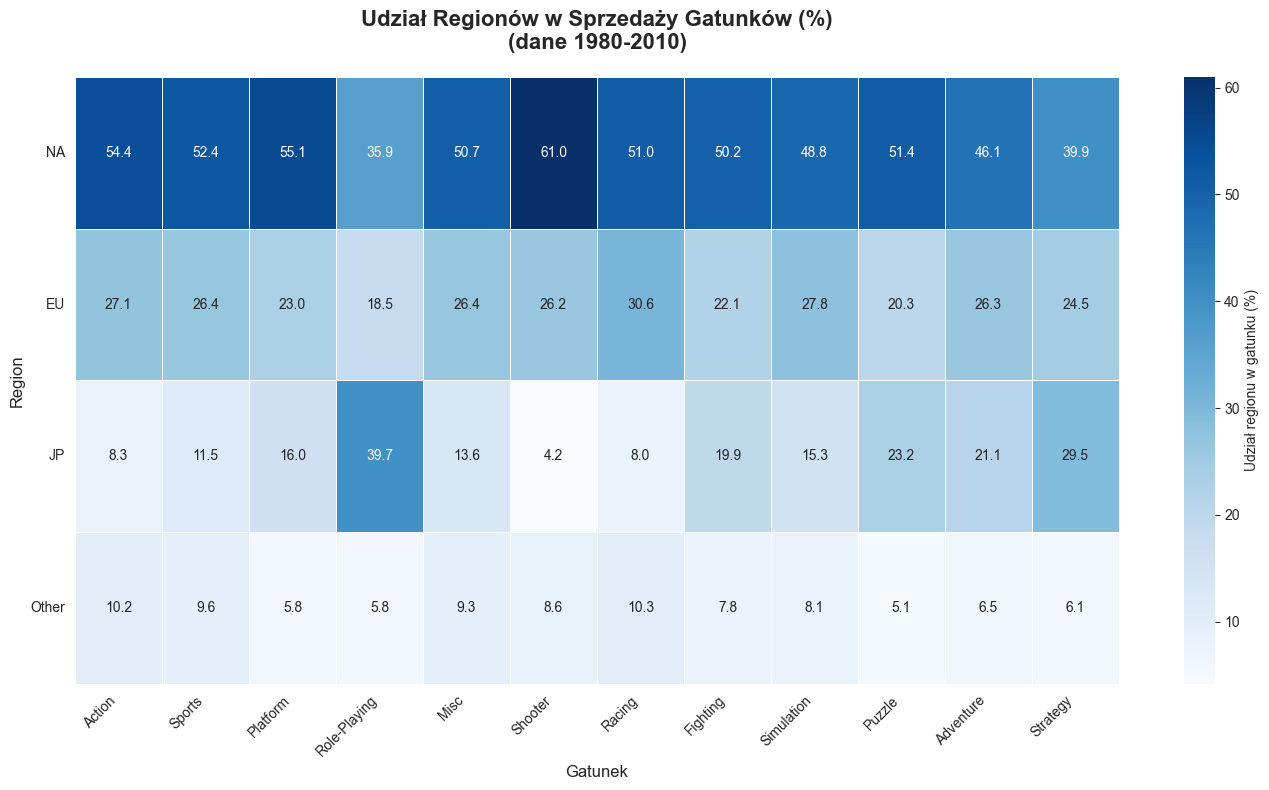

In [24]:
# Przygotowanie danych dla heatmapy region vs gatunek
def create_region_genre_heatmap(df):
    # Przekształcenie danych - melt regionów
    regions_df = pd.melt(df, 
                        id_vars=['Genre'], 
                        value_vars=['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'],
                        var_name='Region', value_name='Sales')
    
    # Oczyszczenie nazw regionów
    regions_df['Region'] = regions_df['Region'].str.replace('_Sales', '')
    
    # Agregacja sprzedaży według regionu i gatunku
    heatmap_data = regions_df.groupby(['Region', 'Genre'])['Sales'].sum().unstack(fill_value=0)
    
    # Sortowanie regionów według całkowitej sprzedaży
    region_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.loc[region_totals.index]
    
    # Sortowanie gatunków według całkowitej sprzedaży
    genre_totals = heatmap_data.sum(axis=0).sort_values(ascending=False)
    heatmap_data = heatmap_data[genre_totals.index]
    
    return heatmap_data

# Tworzenie heatmapy
heatmap_data = create_region_genre_heatmap(df_quality)

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, 
            annot=True,           # Pokazuj wartości
            fmt='.0f',           # Format bez miejsc po przecinku  
            cmap='YlOrRd',       # Mapa kolorów
            cbar_kws={'label': 'Sprzedaż (miliony)'},
            linewidths=0.5)      # Linie między komórkami

plt.title('Sprzedaż według Regionu i Gatunku\n(dane 1980-2010)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gatunek', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Dodatkowa analiza - procentowy udział każdego regionu w gatunku
plt.figure(figsize=(14, 8))
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=0), axis=1) * 100
sns.heatmap(heatmap_percent, 
            annot=True,
            fmt='.1f',
            cmap='Blues',
            cbar_kws={'label': 'Udział regionu w gatunku (%)'},
            linewidths=0.5)

plt.title('Udział Regionów w Sprzedaży Gatunków (%)\n(dane 1980-2010)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Gatunek', fontsize=12) 
plt.ylabel('Region', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()